# Olympic 100m sprint


In [1]:
import numpy as np
from urllib.request import urlopen
from scipy.stats import norm
from tqdm import tqdm

In [2]:
X = [[], []]
y = [[], []]
with urlopen("""https://raw.githubusercontent.com/fredrikwahlberg/5LN445/master/Olympic%20100m%20sprint.csv""") as datafile:
  textlines = [textline.decode('utf-8').strip() for textline in datafile.readlines()]
for linenumber, textline in enumerate(textlines):
  if linenumber == 0:
    labels = [l.strip() for l in textline.split(",")]
  else:
    linedata = [item.strip() for item in textline.split(",")]
    year = int(linedata[0])
    t_men = float(linedata[1])
    X[0].append(year)
    y[0].append(t_men)
    if len(linedata[2]) > 0:
      t_women = float(linedata[2])
      X[1].append(year)
      y[1].append(t_women)
for i in range(len(X)):
  X[i] = np.asarray(X[i])
  y[i] = np.asarray(y[i])
  assert len(X[i]) == len(y[i])
print("Labels:", labels)

Labels: ['Year', 'Men', 'Women']


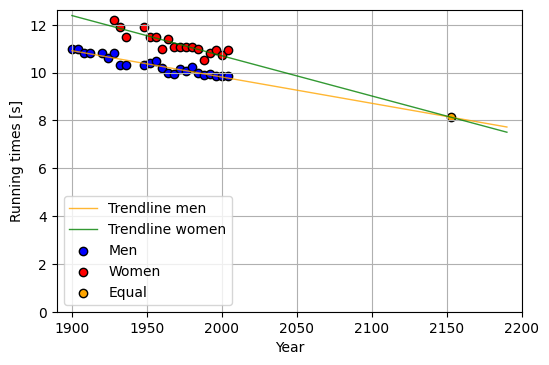

The curves meet in 2152


In [3]:
import matplotlib.pyplot as plt

theta0 = np.ones(6)
theta0[:2] = np.polyfit(X[0], y[0], 1)
theta0[3:5] = np.polyfit(X[1], y[1], 1)

def y_hat(x, theta):
  return [np.asarray(theta[1] + x[0]*theta[0]), 
          np.asarray(theta[4] + x[1]*theta[3])]
cross_point = lambda theta: (theta[1] - theta[4])/(theta[3] - theta[0])

plt.figure(figsize=(6, 4), dpi=100)
plt.scatter(X[0], y[0], color='blue',  edgecolor='k', label="Men")
plt.scatter(X[1], y[1], color='red',  edgecolor='k', label="Women")

x_plot = [np.linspace(1900, 2190, 10)]*2
plt.plot(x_plot[0], y_hat(x_plot, theta0)[0], color='orange', linewidth=1, label="Trendline men", alpha=.8)
plt.plot(x_plot[1], y_hat(x_plot, theta0)[1], color='green', linewidth=1, label="Trendline women", alpha=.8)

x = [cross_point(theta0)]*2
plt.scatter(x[0], y_hat(x, theta0)[0], color='orange',  edgecolor='k', label="Equal")

a = list(plt.axis())
a[0] = 1890
a[1] = 2200
a[2] = 0
plt.axis(a)
plt.grid()
plt.ylabel("Running times [s]")
plt.xlabel("Year")
plt.legend()
plt.show()

print("The curves meet in %i" % cross_point(theta0))

In [4]:
def metropolis_hastings(func, x0, n_iter=1000, scale=0.0002):
  samples = np.zeros((n_iter, len(x0)))
  accepted = np.zeros(n_iter)
  x = np.asarray(x0)
  for iteration in tqdm(range(n_iter), desc="Running Metropolis-Hastings sampling"):
    x_star = x + np.random.normal(scale=scale, size=samples.shape[1])
    if np.log(np.random.rand()) <= (func(x_star) - func(x)):
      x = x_star
      accepted[iteration] = 1
    samples[iteration, :] = x
  return samples, accepted

def logP(theta):
  est = y_hat(X, theta)
  p = np.sum(norm(est[0], theta[2]).logpdf(y[0])) + np.sum(norm(est[1], theta[5]).logpdf(y[1]))
  return p if np.isfinite(p) else -np.inf
P = lambda theta: np.exp(logP(theta))

theta0 += np.random.normal(scale=0.001, size=theta0.shape)
theta0[[2, 5]] = 1

n_burnin = 500
n_samples = 5000
samples, accepted = metropolis_hastings(logP, theta0, n_iter=n_burnin+n_samples)

print(flush=True)
print("Acceptance rate %.1f%%" % (100*np.sum(accepted)/len(accepted)))

D = np.zeros((n_samples, 2))
for i in range(samples.shape[0]-n_burnin):
  D[i, 0] = cross_point(samples[i, :])
  D[i, 1] = y_hat([D[i, 0]]*2, samples[i, :])[0]

Running Metropolis-Hastings sampling: 100%|██████████| 5500/5500 [00:18<00:00, 298.45it/s]


Acceptance rate 33.8%


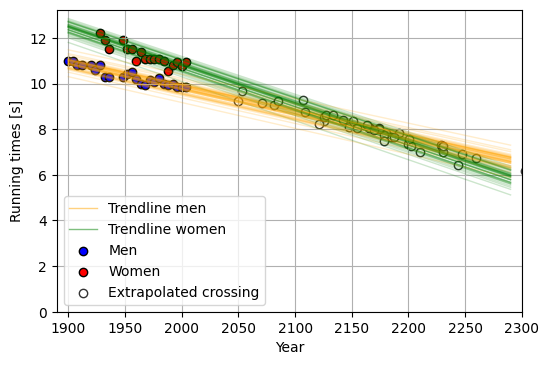

The curves meet in 2155


In [5]:
mu = np.mean(samples[n_burnin:, :], axis=0)
C = np.cov(samples[n_burnin:, :].T)

plt.figure(figsize=(6, 4), dpi=100)
plt.scatter(X[0], y[0], color='blue',  edgecolor='k', label="Men")
plt.scatter(X[1], y[1], color='red',  edgecolor='k', label="Women")

x_plot = [np.linspace(1900, 2290, 10)]*2
for i in range(40):
  theta = np.random.multivariate_normal(mu, C)
  est = y_hat(x_plot, theta)
  x = [cross_point(theta)]*2
  if i == 0:
    plt.plot(x_plot[0], est[0], color='orange', linewidth=1, label="Trendline men", alpha=.5)
    plt.plot(x_plot[1], est[1], color='green', linewidth=1, label="Trendline women", alpha=.5)
    plt.scatter(x[0], y_hat(x, theta)[0], color='white',  edgecolor='k', label="Extrapolated crossing", alpha=.8)
  else:
    plt.plot(x_plot[0], est[0], color='orange', linewidth=1, alpha=.2)
    plt.plot(x_plot[1], est[1], color='green', linewidth=1, alpha=.2)
    plt.scatter(x[0], y_hat(x, theta)[0], color='white',  edgecolor='k', alpha=.8)


a = list(plt.axis())
a[0] = 1890
a[1] = 2300
a[2] = 0
plt.axis(a)
plt.grid()
plt.ylabel("Running times [s]")
plt.xlabel("Year")
plt.legend()
plt.show()

print("The curves meet in %i" % (np.mean(D, axis=0)[0]))

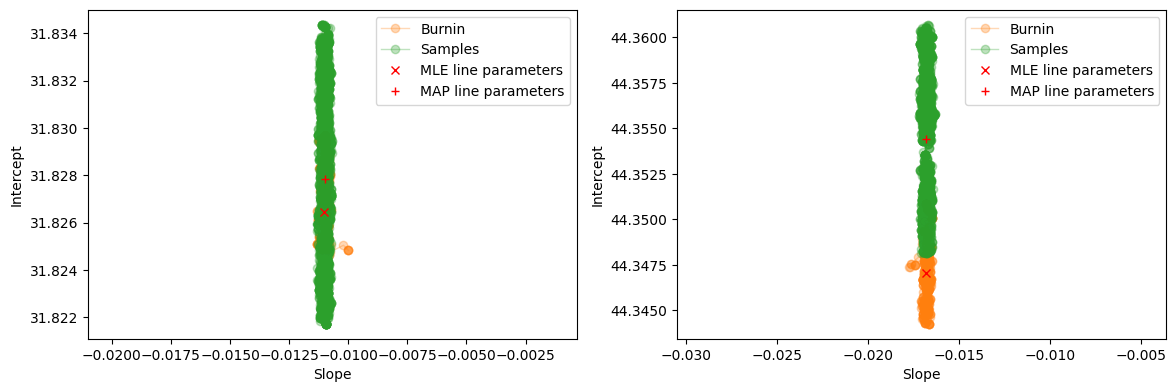

In [6]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.subplots(1, 2)
for i in range(2):
  ax[i].plot(samples[:n_burnin, i*3], samples[:n_burnin, i*3+1], 'o-', color='C1', linewidth=1, label="Burnin", alpha=.3)
  ax[i].plot(samples[n_burnin:, i*3], samples[n_burnin:, i*3+1], 'o-', color='C2', linewidth=1, label="Samples", alpha=.3)
  a, b = np.polyfit(X[i], y[i], 1)
  ax[i].plot(a, b, 'x', color='red', linewidth=3, label="MLE line parameters")
  a, b = np.mean(samples[n_burnin:, i*3:i*3+2], axis=0)
  ax[i].plot(a, b, '+', color='red', linewidth=3, label="MAP line parameters")
for i in range(2):
  ax[i].set_xlabel("Slope")
  ax[i].set_ylabel("Intercept")
  ax[i].legend()
  ax[i].axis('equal')
fig.tight_layout(pad=1)
fig.show()

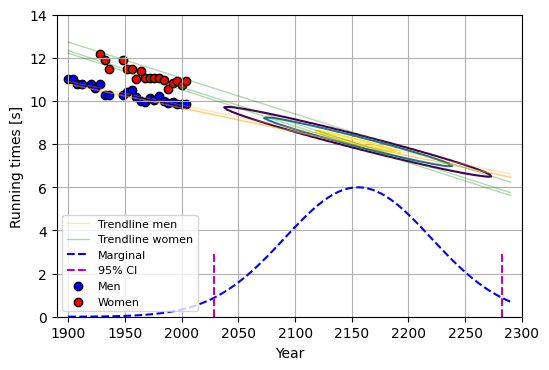

In [7]:
# TODO Animation
from scipy.stats import multivariate_normal

mu = np.mean(samples[n_burnin:, :], axis=0)
C = np.cov(samples[n_burnin:, :].T)

plt.figure(figsize=(6, 4), dpi=100)
plt.scatter(X[0], y[0], color='blue',  edgecolor='k', label="Men")
plt.scatter(X[1], y[1], color='red',  edgecolor='k', label="Women")

D = np.zeros((n_samples, 2))
for i in range(samples.shape[0]-n_burnin):
  D[i, 0] = cross_point(samples[i, :])
  D[i, 1] = y_hat([D[i, 0]]*2, samples[i, :])[0]
Z = np.random.multivariate_normal(np.mean(D, axis=0), np.cov(D.T), size=500)


xx, yy = np.meshgrid(np.arange(2000, 2300, 1),
                      np.arange(6, 10, .1))
grid_coordinates = np.c_[xx.ravel(), yy.ravel()]
V = multivariate_normal(np.mean(D, axis=0), cov=np.cov(D.T))
P = lambda x: V.pdf(x)
Z = np.apply_along_axis(P, 1, grid_coordinates)
Z = Z.reshape(xx.shape)

x_plot = [np.linspace(1900, 2290, 10)]*2
for i in range(3):
  theta = np.random.multivariate_normal(mu, C)
  est = y_hat(x_plot, theta)
  x = [cross_point(theta)]*2
  if i == 0:
    plt.plot(x_plot[0], est[0], color='orange', linewidth=1, label="Trendline men", alpha=.3)
    plt.plot(x_plot[1], est[1], color='green', linewidth=1, label="Trendline women", alpha=.3)
  else:
    plt.plot(x_plot[0], est[0], color='orange', linewidth=1, alpha=.3)
    plt.plot(x_plot[1], est[1], color='green', linewidth=1, alpha=.3)

# plt.scatter(Z[:, 0], Z[:, 1], color='white', edgecolor='k', alpha=1, s=10)
plt.contour(xx, yy, Z, levels=np.percentile(Z.ravel(), [90, 95, 99]))
# plt.hist2d(D[:, 0], D[:, 1], bins=100, cmin=1, cmap='hot')
m, s = np.mean(D[:, 0]), np.std(D[:, 0])
x_plot = np.linspace(x_plot[0].min(), x_plot[0].max(), 100)
p = norm(m, s).pdf(x_plot)
plt.plot(x_plot, 6*p/np.max(p), 'b--', label="Marginal")
plt.plot([m-1.96*s, m-1.96*s], [0, 3], 'm--', label="95% CI")
plt.plot([m+1.96*s, m+1.96*s], [0, 3], 'm--')

a = list(plt.axis())
a[0] = 1890
a[1] = 2300
a[2] = 0
a[3] = 14
plt.axis(a)
plt.grid()
plt.ylabel("Running times [s]")
plt.xlabel("Year")
plt.legend(loc='lower left', fontsize=8)
plt.show()